In [ ]:
import os
import cv2
import numpy as np
from deepface import DeepFace
from time import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
import joblib
import warnings
from tqdm import tqdm
import tensorflow as tf

# Configuración de GPU/CPU y comprobación de disponibilidad de GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.list_physical_devices('GPU')
print("GPUs disponibles:", gpus)
warnings.filterwarnings("ignore")

# --- CONFIGURACIÓN GLOBAL ---
EMBEDDING_MODEL = "VGG-Face"
K_FOLDS = 5
DETECTOR_BACKEND = 'retinaface'

def LoadDataset_Expression(folder, ext):
    """Carga un dataset y extrae características como vectores del mismo retornandolas junto a sus etiquetas."""
    
    X = []
    Y_names = []

    all_files = []
    for class_name in os.listdir(folder):
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            all_files.extend([os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith(ext)])

    total_images = len(all_files)
    print(f"Total de archivos encontrados: {total_images}")
    print(f"Extrayendo embeddings con {EMBEDDING_MODEL}...")

    with tqdm(total=total_images, desc="Extrayendo embeddings") as pbar:
        for img_path in all_files:
            try:
                
                # Extraer embeddings: DeepFace se encarga de la detección y alineación
                embedding_objs = DeepFace.represent(
                    img_path,
                    model_name=EMBEDDING_MODEL,
                    detector_backend=DETECTOR_BACKEND,
                    enforce_detection=False
                )

                # --- Adaptación para el formato de salida de DeepFace ---
                img_embedding = None
                
                if embedding_objs and len(embedding_objs) > 0:
                    
                    # Diferentes versiones de Deepface devuelven los embeddings en estructuras de datos diferentes
                    if isinstance(embedding_objs, list) and isinstance(embedding_objs[0], dict) and "embedding" in embedding_objs[0]:
                        img_embedding = embedding_objs[0]["embedding"]
                    elif isinstance(embedding_objs, list) and all(isinstance(x, (float, np.float32, np.float64)) for x in embedding_objs):
                        img_embedding = embedding_objs
                    
                    # Si hay embedding válido lo añadimos
                    if img_embedding and len(img_embedding) > 0:
                        X.append(img_embedding)
                        Y_names.append(os.path.basename(os.path.dirname(img_path)))

            except Exception as e:
                pass
            pbar.update(1)

    # Convertir a arrays y codificar etiquetas
    X = np.array(X, dtype='float32')
    Y_names = np.array(Y_names)

    if len(X) == 0:
        print("ERROR: No se generaron embeddings válidos.")
        return np.array([]), np.array([]), 0, 0, 0, [], None

    label_encoder = LabelEncoder()
    Y = label_encoder.fit_transform(Y_names)

    n_samples, n_features = X.shape
    n_classes = len(label_encoder.classes_)
    class_names = label_encoder.classes_

    print(f"\nDataset info:\n# samples: {n_samples}\n# features: {n_features}\n# classes: {n_classes}")
    print(f"Classes: {class_names}")

    return X, Y, n_samples, n_features, n_classes, class_names, label_encoder

def train_and_evaluate_model(X, Y, n_classes, class_names, k_folds):
    """Entrena un modelo usando K-Fold Cross-Validation para la evaluación y Support Vector Machines para la clasificación."""

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=4)
    precs_svm, recs_svm = [], []
    final_model = None

    fold = 1
    for train_index, test_index in skf.split(X, Y):
        print(f"\n*** Fold {fold} ***")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        # Normalización
        scaler = MinMaxScaler()
        X_train_norm = scaler.fit_transform(X_train)
        X_test_norm = scaler.transform(X_test)

        # GridSearch SVM
        print("Entrenando SVM (GridSearchCV)...")
        t0 = time()
        params = {'C': [1e3, 5e3, 1e4], 'gamma': [0.0001, 0.001, 0.01]}
        clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced', probability=True),
                           params, cv=3, n_jobs=-1)
        clf.fit(X_train_norm, y_train)
        print(f"Done in {(time() - t0):.2f}s")

        # Predicción y métricas
        y_pred = clf.predict(X_test_norm)
        precs_svm.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        recs_svm.append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

        fold += 1

    # Estadísticas generales.
    print("\n******** K-FOLD SUMMARY ********")
    print(f"Mean Precision: {np.mean(precs_svm):.3f}, Mean Recall: {np.mean(recs_svm):.3f}")

    print("\n--- Entrenando Modelo Final ---")
    final_scaler = MinMaxScaler().fit(X)
    X_norm_final = final_scaler.transform(X)
    final_model = clf.best_estimator_.fit(X_norm_final, Y)

    return final_model, final_scaler


if __name__ == "__main__":
    
    dataset_folder = "./MATERIAL PRACTICA/DATASET/EmotionsDataSet/"

    X, Y, n_samples, n_features, n_classes, class_names, label_encoder = LoadDataset_Expression(dataset_folder, ".png") 
    print("============== Características extraidas============== ")

    if n_samples > 0:
        final_model, final_scaler = train_and_evaluate_model(X, Y, n_classes, class_names, K_FOLDS)
        # Guardar modelos
        joblib.dump(final_model, "svm_expression_model.pkl")
        joblib.dump(final_scaler, "scaler_expression.pkl")
        joblib.dump(label_encoder, "label_encoder_expression.pkl")
        print("\nModelos guardados correctamente.")
    else:
        print("No se generaron embeddings, revisa tu dataset y rutas.")

Done in 1211.81s
              precision    recall  f1-score   support

       angry       0.44      0.51      0.47       152
   disgusted       0.19      0.24      0.21        21
     fearful       0.31      0.27      0.29       169
       happy       0.81      0.70      0.75       265
     neutral       0.54      0.50      0.52       178
         sad       0.44      0.53      0.48       192
   surprised       0.66      0.66      0.66       139

    accuracy                           0.53      1116
   macro avg       0.48      0.49      0.48      1116
weighted avg       0.55      0.53      0.54      1116


*** Fold 2 ***
Entrenando SVM (GridSearchCV)...
Done in 1668.67s
              precision    recall  f1-score   support

       angry       0.39      0.47      0.42       152
   disgusted       0.60      0.29      0.39        21
     fearful       0.29      0.25      0.27       169
       happy       0.74      0.69      0.71       265
     neutral       0.48      0.49      0.49      

In [1]:
import cv2
import numpy as np
from deepface import DeepFace
import joblib
import sys
from PIL import Image


# Cargar modelo
try:
    final_svm_model = joblib.load('svm_expression_model.pkl')
    final_scaler = joblib.load('scaler_expression.pkl')
    label_encoder = joblib.load('label_encoder_expression.pkl')
    class_names = label_encoder.classes_
except FileNotFoundError as e:
    print(f"Error: No se encontraron los archivos del modelo: {e}")
    sys.exit(1)

# Cargar emojis 
try:
    emojis = dict()
    emojis["happy"] = cv2.imread('images/emojis/happy-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["disgusted"] = cv2.imread('images/emojis/disgusted-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["angry"]  = cv2.imread('images/emojis/angry-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["neutral"]  = cv2.imread('images/emojis/neutral-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["fearful"] = cv2.imread('images/emojis/fearful-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["sad"] = cv2.imread('images/emojis/sad-emoji.png', cv2.IMREAD_UNCHANGED)
    emojis["surprised"] = cv2.imread('images/emojis/surprised-emoji.png', cv2.IMREAD_UNCHANGED)

    
except:
    happy_emoji = None

# Configuración
EMBEDDING_MODEL = "VGG-Face"
DETECTOR_BACKEND = "retinaface"

# Webcam
cap = cv2.VideoCapture(0)
gif_frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    detected_expression = "Buscando rostro..."
    
    try:
        faces = DeepFace.extract_faces(frame, detector_backend=DETECTOR_BACKEND)
        
        for face in faces:
            x, y, w, h = face['facial_area']['x'], face['facial_area']['y'], \
                         face['facial_area']['w'], face['facial_area']['h']
            
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            face_img = face['face']
            if face_img.max() <= 1.0:
                face_img = (face_img * 255).astype(np.uint8)
            
            embedding_objs = DeepFace.represent(
                face_img,
                model_name=EMBEDDING_MODEL,
                enforce_detection=False
            )
            
            if embedding_objs:
                embedding = np.array(embedding_objs[0]["embedding"])
                
                # TRUNCAR si tiene más features de las esperadas
                expected_features = final_svm_model.n_features_in_
                if len(embedding) > expected_features:
                    embedding = embedding[:expected_features]
                X_test = embedding.reshape(1, -1)
                X_test = final_scaler.transform(X_test)
                
                predicted_class_num = final_svm_model.predict(X_test)
                predicted_expression = label_encoder.inverse_transform(predicted_class_num)[0]
                detected_expression = predicted_expression
                cv2.putText(frame, detected_expression, (x, y - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                
                if emojis[detected_expression] is not None:
                    # Redimensionar el emoji al tamaño del bounding box (w, h)
                    emoji_resized = cv2.resize(emojis[detected_expression], (w, h))

                    # Nos quedamos con la region de interés
                    y1, y2 = max(0, y), min(frame.shape[0], y + h)
                    x1, x2 = max(0, x), min(frame.shape[1], x + w)

                    # Si las dimensiones redimensionadas no coinciden con el recorte, ajustamos el recorte
                    h_roi = y2 - y1
                    w_roi = x2 - x1
                    
                    if h_roi > 0 and w_roi > 0:
                        b, g, r, alpha = cv2.split(emoji_resized)
                        alpha_norm = alpha / 255.0 
                        alpha_inv = 1.0 - alpha_norm
                        emoji_bgr = cv2.merge([b, g, r]).astype(float)
                        roi = frame[y1:y2, x1:x2].astype(float)
                        background = cv2.multiply(roi, cv2.merge([alpha_inv, alpha_inv, alpha_inv]))
                        foreground = cv2.multiply(emoji_bgr, cv2.merge([alpha_norm, alpha_norm, alpha_norm]))
                        blended = cv2.add(background, foreground)    
                        frame[y1:y2, x1:x2] = blended.astype(np.uint8)
        
    except Exception as e:
        print(f"Error: {e}")
    
    cv2.putText(frame, f"Expresion: {detected_expression}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    cv2.imshow("Filtro de emociones con emoticonos", frame)
    gif_frames.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

""" 
DESCOMENTAR SI SE QUIERE GUARDAR UN GIF
if len(gif_frames) > 0:
    gif_frames[0].save(
        "emotions.gif",
        save_all=True,
        append_images=gif_frames[1:],
        duration=100,  
        loop=0
    )
    print("GIF guardado como output.gif")
"""

2025-11-16 19:13:35.041909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-16 19:13:35.041951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-16 19:13:35.042949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-16 19:13:35.048392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 19:13:35.827155: W tensorflow/compiler/tf2

' \nDESCOMENTAR SI SE QUIERE GUARDAR UN GIF\nif len(gif_frames) > 0:\n    gif_frames[0].save(\n        "emotions.gif",\n        save_all=True,\n        append_images=gif_frames[1:],\n        duration=100,  \n        loop=0\n    )\n    print("GIF guardado como output.gif")\n'

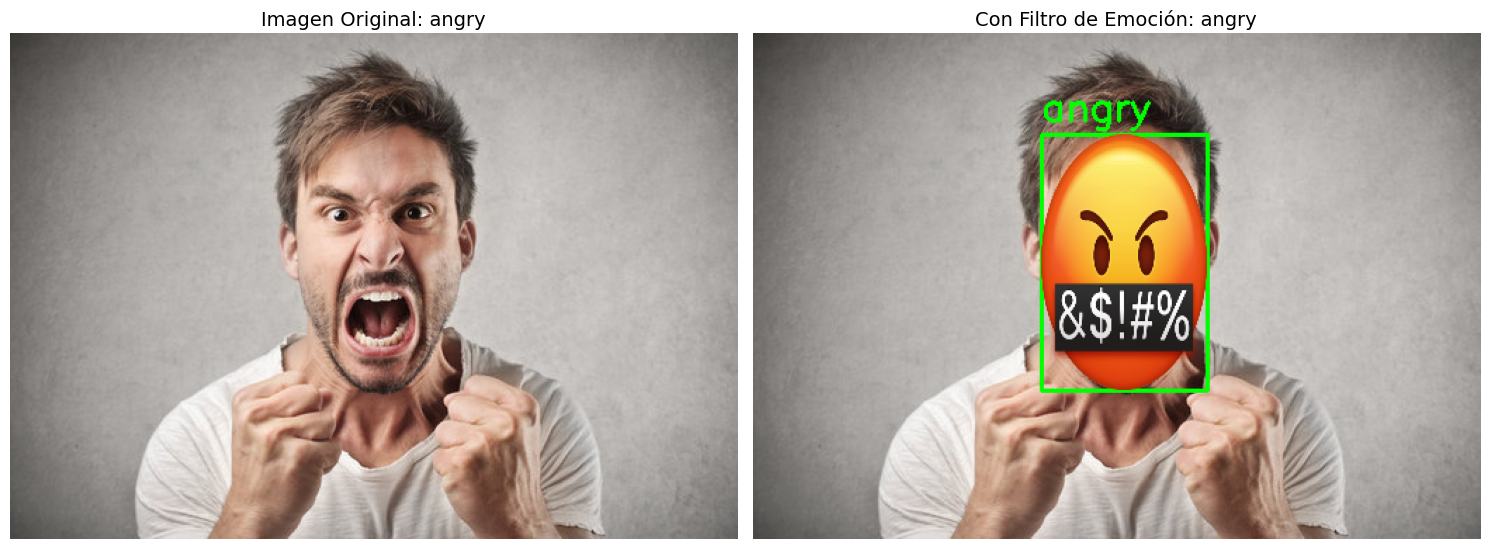

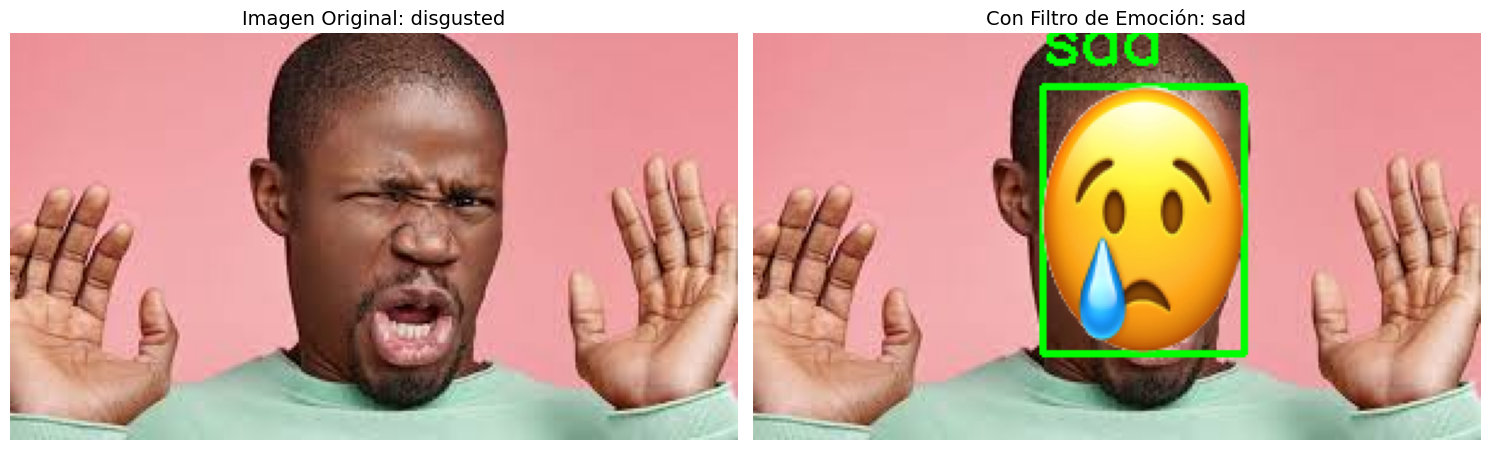

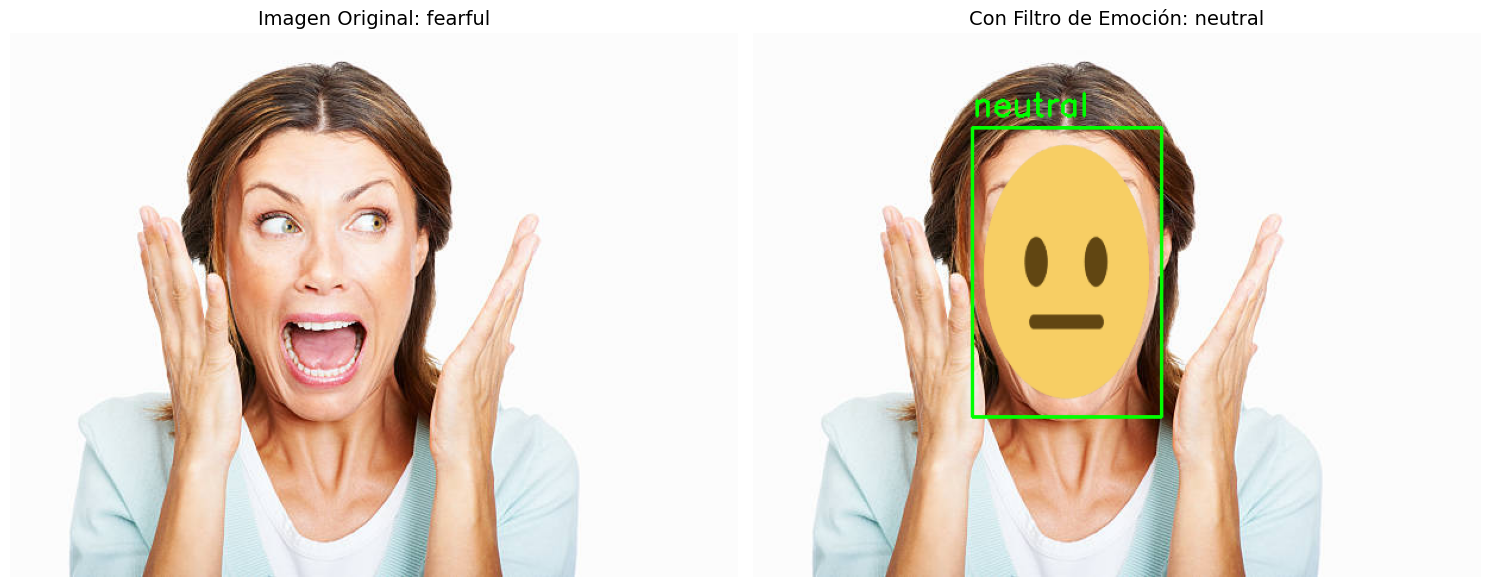

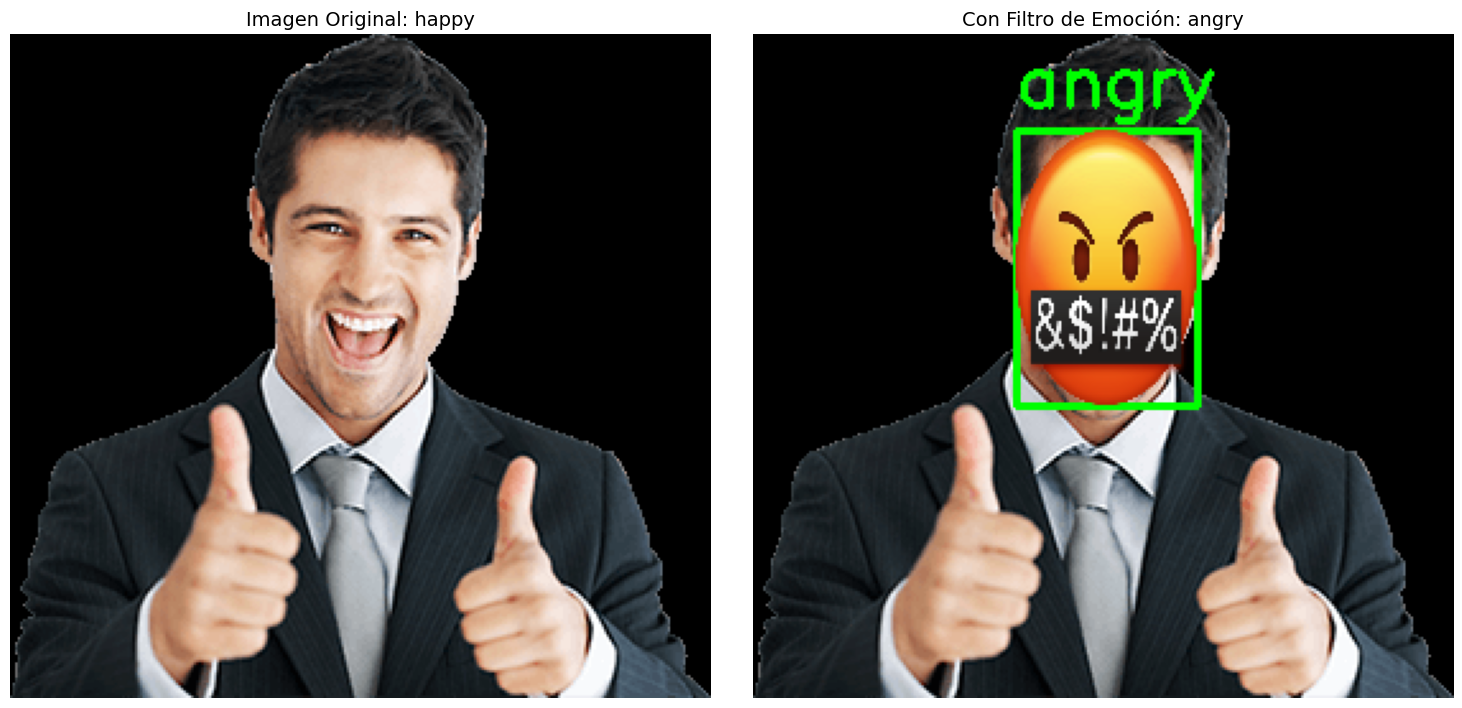

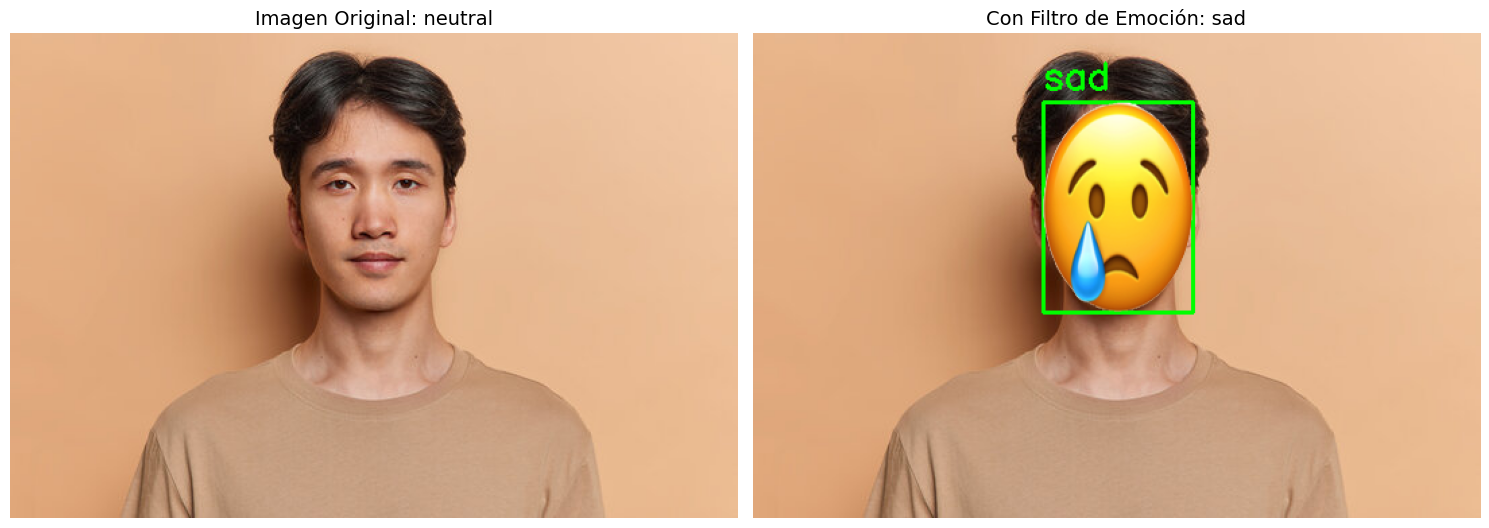

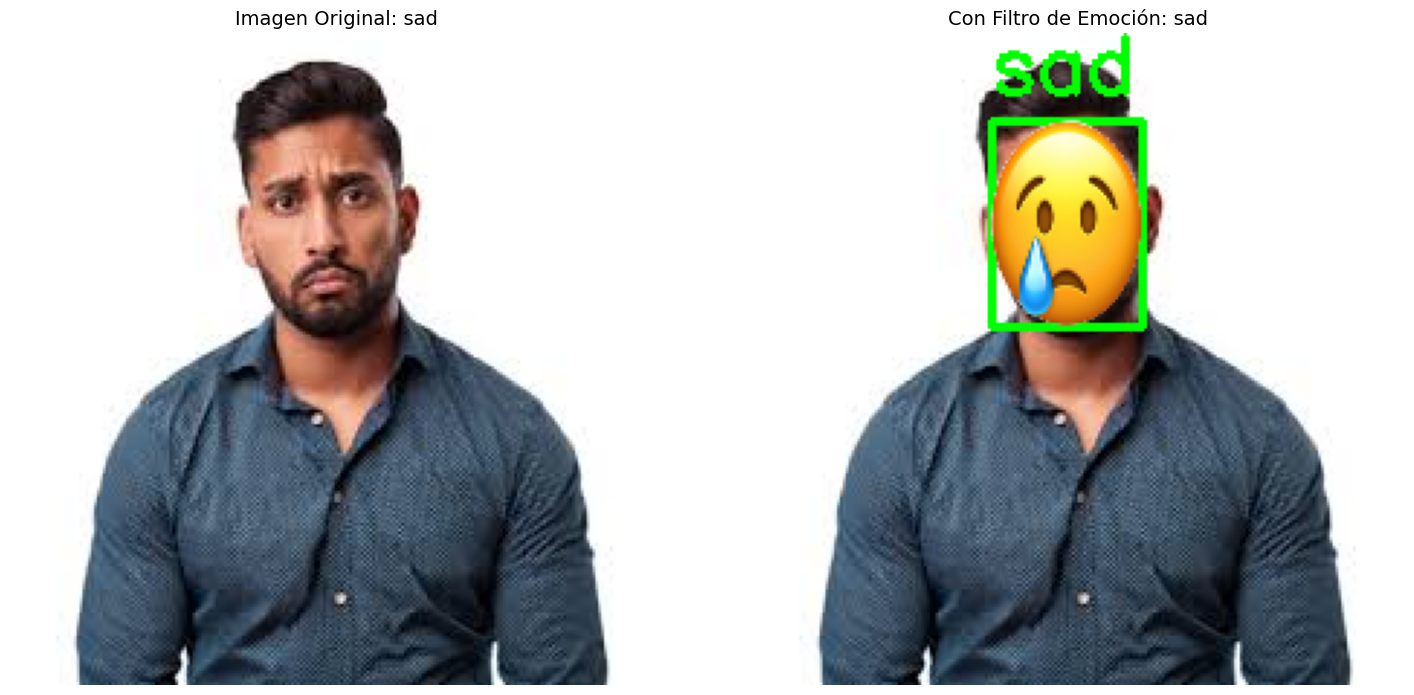

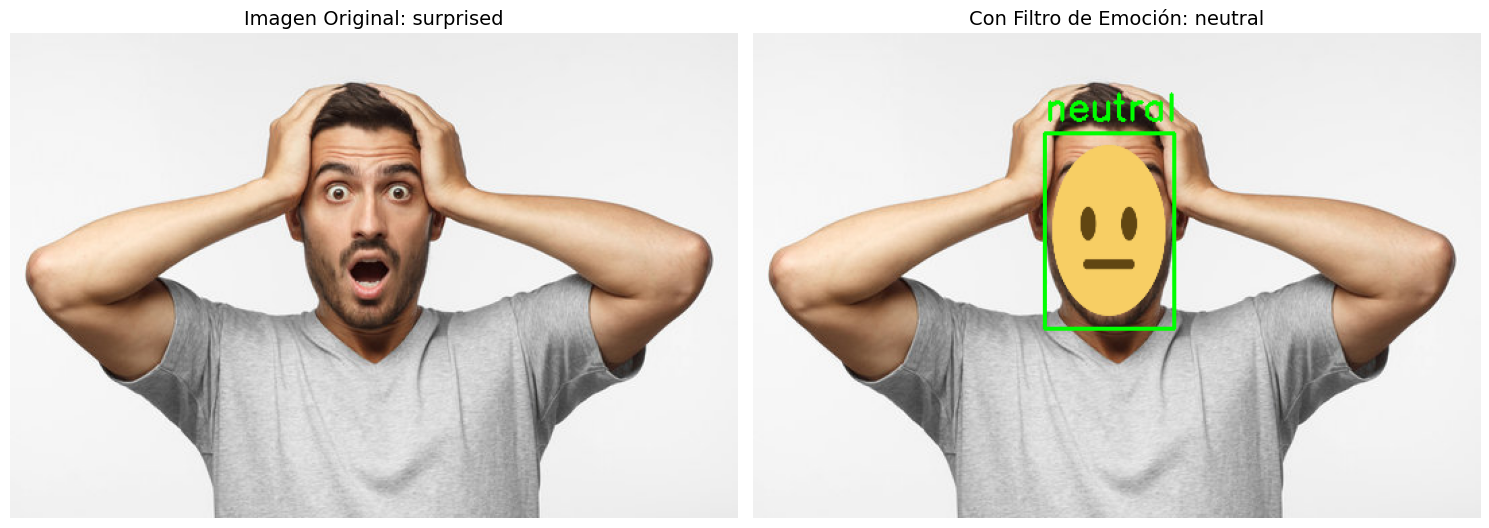

In [8]:
import cv2
import numpy as np
from deepface import DeepFace
import joblib
import sys
from PIL import Image
import matplotlib.pyplot as plt
import os


def apply_emotion_filter(image_path):
    """
    Aplica el filtro de emociones a una imagen y muestra comparativa original vs procesada.
    Devuelve la imagen resultado y la comparativa.
    """
    # Cargar modelo
    try:
        final_svm_model = joblib.load('svm_expression_model.pkl')
        final_scaler = joblib.load('scaler_expression.pkl')
        label_encoder = joblib.load('label_encoder_expression.pkl')
        class_names = label_encoder.classes_
    except FileNotFoundError as e:
        print(f"Error: No se encontraron los archivos del modelo: {e}")
        sys.exit(1)

    # Cargar emojis (con transparencia)
    try:
        emojis = dict()
        emojis["happy"] = cv2.imread('images/emojis/happy-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["disgusted"] = cv2.imread('images/emojis/disgusted-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["angry"] = cv2.imread('images/emojis/angry-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["neutral"] = cv2.imread('images/emojis/neutral-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["fearful"] = cv2.imread('images/emojis/fearful-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["sad"] = cv2.imread('images/emojis/sad-emoji.png', cv2.IMREAD_UNCHANGED)
        emojis["surprised"] = cv2.imread('images/emojis/surprised-emoji.png', cv2.IMREAD_UNCHANGED)
    except Exception as e:
        print(f"Advertencia: Error cargando emojis: {e}")
        emojis = {key: None for key in ["happy", "disgusted", "angry", "neutral", "fearful", "sad", "surprised"]}

    # Configuración
    EMBEDDING_MODEL = "VGG-Face"
    DETECTOR_BACKEND = "retinaface"

    # Cargar imagen
    frame = cv2.imread(image_path)
    if frame is None:
        print(f"Error: No se pudo cargar la imagen {image_path}")
        return
    
    # Guardar copia original
    original = frame.copy()
    
    detected_expression = "No se detectó rostro"
    
    try:
        faces = DeepFace.extract_faces(frame, detector_backend=DETECTOR_BACKEND)
        
        for face in faces:
            x, y, w, h = face['facial_area']['x'], face['facial_area']['y'], \
                         face['facial_area']['w'], face['facial_area']['h']
            
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            face_img = face['face']
            if face_img.max() <= 1.0:
                face_img = (face_img * 255).astype(np.uint8)
            
            embedding_objs = DeepFace.represent(
                face_img,
                model_name=EMBEDDING_MODEL,
                enforce_detection=False
            )
            
            if embedding_objs:
                embedding = np.array(embedding_objs[0]["embedding"])
                
                # TRUNCAR si tiene más features de las esperadas
                expected_features = final_svm_model.n_features_in_
                if len(embedding) > expected_features:
                    embedding = embedding[:expected_features]
                
                X_test = embedding.reshape(1, -1)
                X_test = final_scaler.transform(X_test)
                
                # Predicción
                predicted_class_num = final_svm_model.predict(X_test)
                predicted_expression = label_encoder.inverse_transform(predicted_class_num)[0]
                detected_expression = predicted_expression
                
                cv2.putText(frame, detected_expression, (x, y - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                
                if emojis.get(detected_expression) is not None:
                    # Redimensionar el emoji al tamaño del bounding box (w, h)
                    emoji_resized = cv2.resize(emojis[detected_expression], (w, h))

                    # roi
                    y1, y2 = max(0, y), min(frame.shape[0], y + h)
                    x1, x2 = max(0, x), min(frame.shape[1], x + w)

                    # Si las dimensiones redimensionadas no coinciden con el recorte, ajustamos el recorte
                    h_roi = y2 - y1
                    w_roi = x2 - x1
                    
                    if h_roi > 0 and w_roi > 0:
                        emoji_resized = cv2.resize(emojis[detected_expression], (w_roi, h_roi))
                        b, g, r, alpha = cv2.split(emoji_resized)
                        alpha_norm = alpha / 255.0 
                        alpha_inv = 1.0 - alpha_norm
                        emoji_bgr = cv2.merge([b, g, r]).astype(float)
                        roi = frame[y1:y2, x1:x2].astype(float)
                        background = cv2.multiply(roi, cv2.merge([alpha_inv, alpha_inv, alpha_inv]))
                        foreground = cv2.multiply(emoji_bgr, cv2.merge([alpha_norm, alpha_norm, alpha_norm]))
                        blended = cv2.add(background, foreground)    
                        frame[y1:y2, x1:x2] = blended.astype(np.uint8)
        
    except Exception as e:
        print(f"Error procesando rostros: {e}")
    

    filename = os.path.basename(image_path)  
    emotion = filename.rsplit(".", 1)[0].split("-")[0] # Extraer nombre de la emoción del nombre de la imagen

    # Mostrar comparativa
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Imagen Original: {emotion}', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'Con Filtro de Emoción: {detected_expression}', fontsize=14)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    comparativa = np.array(fig.canvas.renderer.buffer_rgba()) # Extraemos la imagen comparativa para devolverla

    return frame, comparativa



CARPETA = "images/emoji-test/"
CARPETA_SALIDA = "images/results/emoji"
os.makedirs(CARPETA_SALIDA, exist_ok=True)
for archivo in os.listdir(CARPETA):
    if archivo.lower().endswith((".jpg", ".jpeg", ".png")):
        ruta = os.path.join(CARPETA, archivo)
        processed_image, comparativa = apply_emotion_filter(ruta)
        img_rgb = cv2.cvtColor(comparativa, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(comparativa[:, :, :3])
        pil_img.save(f"{CARPETA_SALIDA}/{archivo}")
